In [21]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, assemble,transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import UGate
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import math

# Phase 1

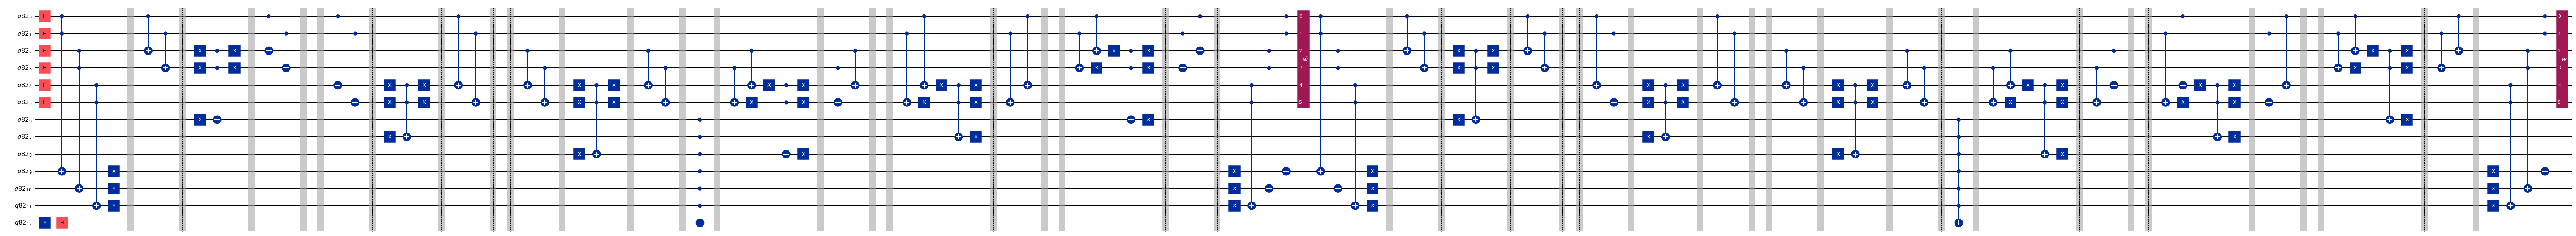

In [59]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import math

num_city = 3
bidgt = int(math.ceil(math.log2(num_city)))
qnum_city = num_city * bidgt
qnum = 13

def nand(qc, q1, q2, ac):
    #qc.barrier()
    qc.ccx(q1, q2, ac)
    qc.x(ac)
    
def inand(qc, q1, q2, ac):
    qc.x(ac)
    qc.ccx(q1, q2, ac)

def diffuser(nqubits):
    qc2 = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc2.h(qubit)
    for qubit in range(nqubits):
        qc2.x(qubit)
    qc2.h(nqubits-1)
    qc2.mcx(list(range(nqubits-1)), nqubits-1)  
    qc2.h(nqubits-1)
    for qubit in range(nqubits):
        qc2.x(qubit)
    for qubit in range(nqubits):
        qc2.h(qubit)
    U_s = qc2.to_gate()
    U_s.name = "$\hat{W}$"
    return U_s

def qOR(qc, q1, q2, ac):
    qc.barrier()
    qc.x(q1)
    qc.x(q2)
    qc.x(ac)
    qc.ccx(q1, q2, ac)
    qc.x(q1)
    qc.x(q2)
    qc.barrier()

def iqOR(qc, q1, q2, ac):
    qc.x(q2)
    qc.x(q1)
    qc.ccx(q1, q2, ac)
    qc.x(ac)
    qc.x(q2)
    qc.x(q1)
    qc.barrier()

def checker(qc, ac1, ac2, acout):
    # CHECK IF SAME OR NOT
    qc.barrier()
    qc.cx(ac1 * bidgt, ac2 * bidgt)
    qc.cx((ac1 * bidgt) + 1, (ac2 * bidgt) + 1)
    qOR(qc, ac2 * bidgt, (ac2 * bidgt) + 1, acout)
    # REVERSE
    qc.cx(ac1 * bidgt, ac2 * bidgt)
    qc.cx((ac1 * bidgt) + 1, (ac2 * bidgt) + 1)
    qc.barrier()

def ichecker(qc, ac1, ac2, acout):
    # REVERSE
    qc.barrier()
    qc.cx((ac1 * bidgt) + 1, (ac2 * bidgt) + 1)
    qc.cx(ac1 * bidgt, ac2 * bidgt)
    iqOR(qc, ac2 * bidgt, (ac2 * bidgt) + 1, acout)
    qc.cx((ac1 * bidgt) + 1, (ac2 * bidgt) + 1)
    qc.cx(ac1 * bidgt, ac2 * bidgt)    
    qc.barrier()

qanc = [6,7,8,9,10,11]
qr = QuantumRegister(qnum)
qc_grover = QuantumCircuit(qr, name="<0|G^2")

qc_grover.h([i for i in range(qnum_city)])
qc_grover.x(qr[qnum-1])
qc_grover.h(qr[qnum-1])

for i in range(2):
    nand(qc_grover, 0, 1, 9)
    nand(qc_grover, 2, 3, 10)
    nand(qc_grover, 4, 5, 11)
    checker(qc_grover, 0, 1, 6)
    checker(qc_grover, 0, 2, 7)
    checker(qc_grover, 1, 2, 8)
    qc_grover.mcx(qanc, qnum - 1)
    ichecker(qc_grover, 1, 2, 8)
    ichecker(qc_grover, 0, 2, 7)
    ichecker(qc_grover, 0, 1, 6) 
    inand(qc_grover, 4, 5, 11)
    inand(qc_grover, 2, 3, 10)
    inand(qc_grover, 0, 1, 9)
    qc_grover.append(diffuser(qnum_city), range(qnum_city))

    
qc_grover.draw("mpl",style="iqp",fold=-1)

In [115]:
qr = QuantumRegister(qnum)
cr = ClassicalRegister(qnum_city)
qc_total = QuantumCircuit(qr,cr)
#qc_total = QuantumCircuit(qr)
qc_total.append(qc_grover, qargs = qr)


for i in range(8):
    qc_total.append(qc_cost,qr[:6])

    #Grover diffuser
    qc_total.append(qc_grover.inverse(),qargs = qr)
    # 全ての量子ビットにパウリ-Xゲートを適用
    qc_total.x(range(qnum_city))
    qc_total.barrier()
    # マルチ制御Xゲート（mcx）を適用
    qc_total.h(qnum_city - 1)
    qc_total.mcx(list(range(qnum_city - 1)), qnum_city - 1)  # マルチ制御X
    qc_total.h(qnum_city - 1)
    qc_total.barrier()
    # 再び全ての量子ビットにパウリ-Xゲートを適用
    qc_total.x(range(qnum_city))
    qc_total.append(qc_grover,qargs = qr)


for i in range(qnum_city):
    qc_total.measure(i,i)


#qc_total.draw("mpl",style="iqp",fold=-1)

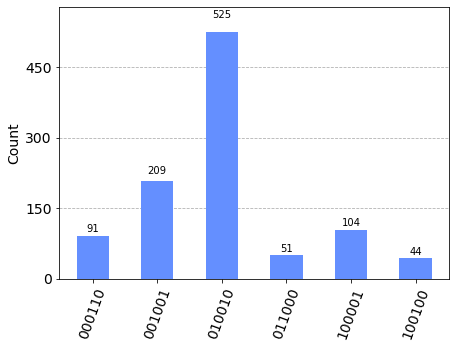

In [116]:
# バックエンドを設定します
#ヒストグラムから最適化したい場合
backend = Aer.get_backend('qasm_simulator')
# 量子回路をトランスパイルします
transpiled_circuit = transpile(qc_total, backend=backend)
# トランスパイルされた回路を実行して結果を取得します
job = backend.run(transpiled_circuit, shots=1024)
results = job.result()

# 測定結果を取得します
counts = results.get_counts()
#target_state = AerSimulator().run(qc.measure_all(inplace=False)).result().get_counts()
plot_histogram(counts)

# 一つの回路にまとめる

In [57]:
qc_total.append(qc_grover.inverse(),qargs = qr)

In [99]:
from qiskit import QuantumCircuit

qc_total.append(qc_grover.inverse())

# Step 1: 制御されたユニタリー演算子 (CU) の作成
ket_s_dag = qc_grover.inverse()

# Step 2: 2|s><s| を作成
qc_2s_s = QuantumCircuit(qnum)
qc_2s_s.barrier()
qc_2s_s.h(range(qnum))
qc_2s_s.z(range(qnum))
qc_2s_s.h(range(qnum))
qc_2s_s.barrier()

# Step 3: 単位行列 I を作成
qc_I = QuantumCircuit(qnum)


# Step 4: Grover diffuser の構築
qc_diffuser = qc_cu.compose(qc_2s_s, qubits=range(qnum)).compose(qc_I, qubits=range(qnum))

qc_diffuser.draw("mpl",style="iqp",fold=-1)


CircuitError: 'The amount of qubit arguments 0 does not match the instruction expectation (13).'

# ヒストグラムから最適化したい場合

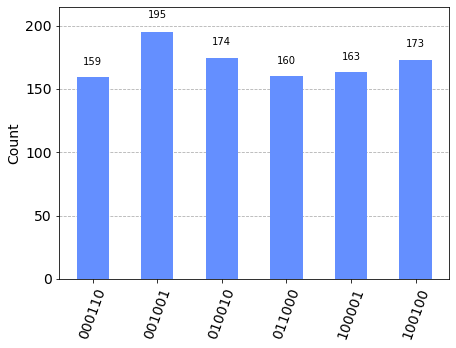

In [53]:
# バックエンドを設定します
#ヒストグラムから最適化したい場合
backend = Aer.get_backend('qasm_simulator')
# 量子回路をトランスパイルします
transpiled_circuit = transpile(qc_total, backend=backend)
# トランスパイルされた回路を実行して結果を取得します
job = backend.run(transpiled_circuit, shots=1024)
results = job.result()

# 測定結果を取得します
counts = results.get_counts()
#target_state = AerSimulator().run(qc.measure_all(inplace=False)).result().get_counts()
plot_histogram(counts)

In [28]:
def counts_to_distr(counts):
    n_shots = sum(counts.values())
    return {int(k,2): v/n_shots for k, v in counts.items()}

target_state = counts_to_distr(counts)
target_state

{44: 0.0009765625,
 46: 0.0009765625,
 6: 0.16015625,
 36: 0.1669921875,
 33: 0.1669921875,
 18: 0.1708984375,
 9: 0.162109375,
 24: 0.1708984375}

In [714]:
ket_s = np.zeros(2**qnum_city)
for k, v in target_state.items():
    ket_s[k] = v
ket_s /= np.linalg.norm(init) 
ket_s

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16699219, 0.        , 0.        , 0.17480469,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.15625   , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15527344,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.16015625, 0.        ,
       0.        , 0.18652344, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [722]:
import numpy as np


# ket_s ベクトルのノルムを計算
ket_s_norm = np.linalg.norm(ket_s)

# ket_s ベクトルを正規化
ket_s_normalized = ket_s / ket_s_norm

# 密度行列 rho を計算
rho = np.outer(ket_s_normalized, np.conj(ket_s_normalized))

# 単位行列を作成
I = np.eye(len(ket_s))

# ユニタリー行列を作成
U_w = 2 * rho - I

# U がユニタリー行列であることを確認
is_unitary = np.allclose(np.eye(len(U_w)), U_w @ U_w.T.conj())

print("Is U_w a unitary matrix?", is_unitary)

Is U_w a unitary matrix? True


In [723]:
num_qubits = int(np.log2(len(ket_s)))
qr = QuantumRegister(num_qubits, 'q')
num_qubits

6

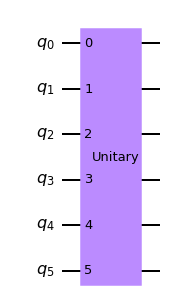

In [724]:
qc = QuantumCircuit(qr,name="|s>")

# UをOperatorクラスに変換
U_operator = Operator(U_w)

# Operatorを量子回路に追加
qc.append(U_operator, qr)
qc.draw("mpl")

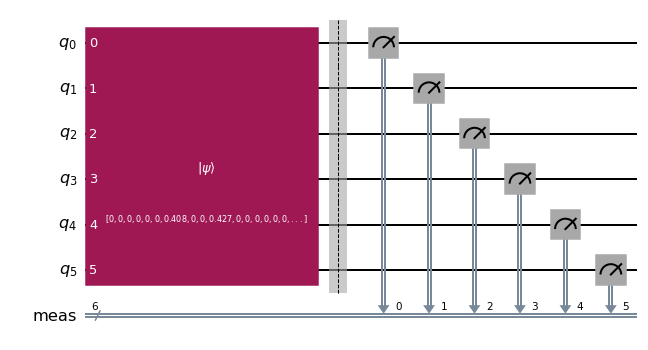

In [672]:
qc = QuantumCircuit(qr,name="|s>")

# 回路を |data(k)> 状態で初期化
qc.initialize(init, [i for i in range(qnum_city)])
qc.measure_all()
qc.draw("mpl",style="iqp",fold=-1)

In [669]:
from qiskit.quantum_info import Operator

# 量子回路の初期化
qc = QuantumCircuit(qnum_city, name="|s>")
qc.initialize(init, [i for i in range(qnum_city)])

# 初期状態を逆にするための逆ユニタリー操作
inverse_init_op = init.conj().T

# 逆ユニタリー操作を量子回路に追加
#qc.append(Operator(inverse_init_op), range(qnum_city))

# 測定操作を逆にする
qc.measure_all()

# 量子回路の描画
qc.draw("mpl", style="iqp", fold=-1)


CircuitError: 'inverse() not implemented for measure.'

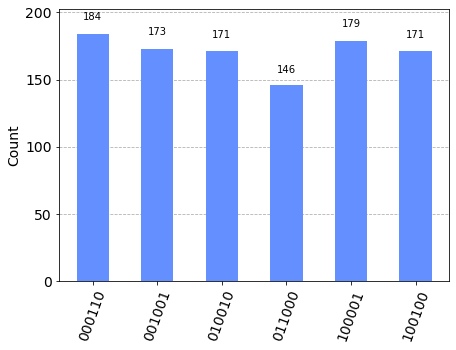

In [645]:
from qiskit.providers.aer import AerSimulator
# バックエンドを設定します
#ヒストグラムから最適化したい場合
backend = Aer.get_backend('qasm_simulator')
# 量子回路をトランスパイルします
transpiled_circuit = transpile(qc, backend=backend)
# トランスパイルされた回路を実行して結果を取得します
job = backend.run(transpiled_circuit, shots=1024)
results = job.result()

# 測定結果を取得します
counts = results.get_counts()
plot_histogram(counts)

# コストオラクル作成

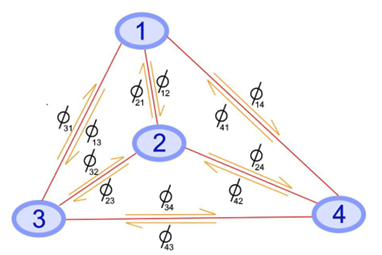

In [113]:
import numpy as np

np.random.seed(42)

tour_weight = np.random.randint(0, 100, size=qnum_city)
print(tour_weight)
#重みが軽い状態をpiに近づけるため、重みを逆数にする
tour_weight = 1/tour_weight
#tour_weight = tour_weight/(np.max(tour_weight)-np.min(tour_weight))
print(tour_weight)
# 整数から浮動小数点数に変換して重みを正規化する
tour_weight = tour_weight.astype(float) / np.max(tour_weight)
#tour_weight = tour_weight.astype(float) / np.linalg.norm(tour_weight)
#tour_weight *= 2 * np.pi
tour_weight

[51 92 14 71 60 20]
[0.01960784 0.01086957 0.07142857 0.01408451 0.01666667 0.05      ]


array([0.2745098 , 0.15217391, 1.        , 0.1971831 , 0.23333333,
       0.7       ])

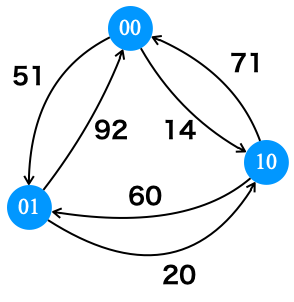

In [107]:
from qiskit.circuit.library.standard_gates.p import MCPhaseGate


def cost_oracle(cost_value, cost_label):
    num_ctrl_qubits = qnum_city
    
    qc = QuantumCircuit(num_ctrl_qubits,name=cost_label)
    
    # cost_labelの各桁に対してXゲートを適用
    for i, bit in enumerate(cost_label):
        if bit == '0':
            qc.x(i)

    # MCPhaseGateを適用
    mcphase_gate = MCPhaseGate(lam=cost_value, num_ctrl_qubits=num_ctrl_qubits-1)
    qc.append(mcphase_gate, range(num_ctrl_qubits))
    
    # Xゲートをリセット
    for i, bit in enumerate(cost_label):
        if bit == '0':
            qc.x(i)

    return qc

cost_oracle(-0.01, "000110").draw()

┌───┐           ┌───┐
q_0: ┤ X ├─■─────────┤ X ├
     ├───┤ │         ├───┤
q_1: ┤ X ├─■─────────┤ X ├
     ├───┤ │         ├───┤
q_2: ┤ X ├─■─────────┤ X ├
     └───┘ │         └───┘
q_3: ──────■──────────────
           │              
q_4: ──────■──────────────
     ┌───┐ │P(-0.01) ┌───┐
q_5: ┤ X ├─■─────────┤ X ├
     └───┘           └───┘

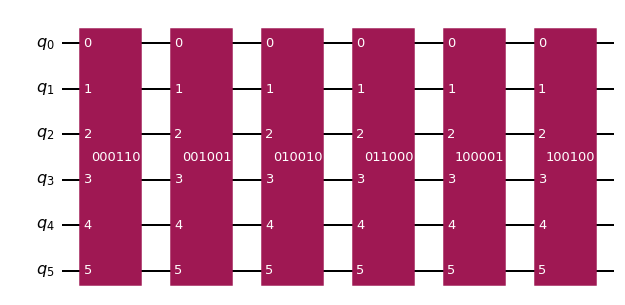

In [114]:

qr = QuantumRegister(qnum_city, 'q')
qc_cost = QuantumCircuit(qr,name="cost oracle")

def cost_oracle(cost_value, cost_label):
    num_ctrl_qubits = qnum_city
    
    qc = QuantumCircuit(num_ctrl_qubits,name=cost_label)
    
    # cost_labelの各桁に対してXゲートを適用
    for i, bit in enumerate(cost_label):
        if bit == '0':
            qc.x(i)

    # MCPhaseGateを適用
    mcphase_gate = MCPhaseGate(lam=cost_value, num_ctrl_qubits=num_ctrl_qubits-1)
    qc.append(mcphase_gate, range(num_ctrl_qubits))
    
    # Xゲートをリセット
    for i, bit in enumerate(cost_label):
        if bit == '0':
            qc.x(i)

    return qc


w1 = tour_weight[0]
w2 = tour_weight[1]

w3 = tour_weight[2]
w4 = tour_weight[3]

w5 = tour_weight[4]
w6 = tour_weight[5]

#making e^{iθ1}|00>|01>

    #qc_cost.append(cost_oracle(-w0001, "0001"), i)
    #qc_cost.append(cost_oracle(-w0010, "0010"), i)
    #qc_cost.append(cost_oracle(-w0001, "0100"), i)
    #qc_cost.append(cost_oracle(-w0010, "0110"), i)
    #qc_cost.append(cost_oracle(-w0001, "1000"), i)
    #qc_cost.append(cost_oracle(-w0010, "1001"), i)
    
qc_cost.append(cost_oracle(w1*math.pi, "000110"), [i for i in range(qnum_city)])
qc_cost.append(cost_oracle(w2*math.pi, "001001"), [i for i in range(qnum_city)])
qc_cost.append(cost_oracle(w3*math.pi, "010010"), [i for i in range(qnum_city)])
qc_cost.append(cost_oracle(w4*math.pi, "011000"), [i for i in range(qnum_city)])
qc_cost.append(cost_oracle(w5*math.pi, "100001"), [i for i in range(qnum_city)])
qc_cost.append(cost_oracle(w6*math.pi, "100100"), [i for i in range(qnum_city)])
#making e^{iθ1}|00>|10>
#qc.append(cost_oracle(w0010, "C0C1", "0010"), [0,1,2,3])


qc_cost.draw("mpl",style="iqp",fold=-1)

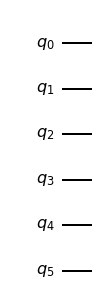

In [757]:
qr = QuantumRegister(qnum_city, 'q')
qc_w = QuantumCircuit(qr)


qc_w.draw("mpl",style="iqp",fold=-1)

In [74]:
qr = QuantumRegister(qnum_city, 'q')
qc_total = QuantumCircuit(qr)

# 回路を |data(k)> 状態で初期化
#qc_total.initialize(init, [i for i in range(qnum_city)])
qc.barrier()

for t in range(1):
    qc_total.append(qc_cost,qr)
    qc.barrier()

    ##Grover diffuser
    U_operator = Operator(U_w)
    qc_total.append(U_operator, qr)


qc_total.measure_all()
qc_total.draw("mpl",style="iqp",fold=-1)

NameError: name 'qc' is not defined

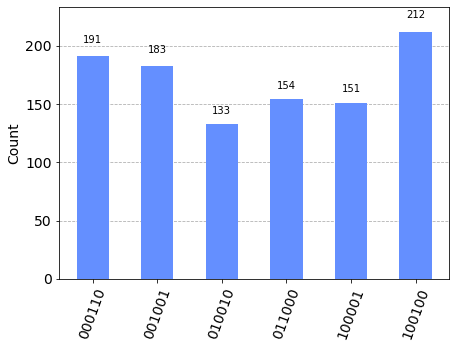

In [754]:
from qiskit.providers.aer import AerSimulator
# バックエンドを設定します
#ヒストグラムから最適化したい場合
backend = Aer.get_backend('qasm_simulator')
# 量子回路をトランスパイルします
transpiled_circuit = transpile(qc_total, backend=backend)
# トランスパイルされた回路を実行して結果を取得します
job = backend.run(transpiled_circuit, shots=1024)
results = job.result()

# 測定結果を取得します
counts = results.get_counts()
plot_histogram(counts)

# #状態ベクトルから最適化したい場合

In [509]:
#アンシラあるから無理かも
phase1_qc = Grover_circ(int(2))
backend = Aer.get_backend('statevector_simulator')
transpiled_circuit = transpile(phase1_qc, backend=backend)
job = backend.run(transpiled_circuit)
target_state = job.result().get_statevector()
print(target_state)

Statevector([0.00138107+5.84351206e-17j, 0.00138107+6.53695343e-17j,
             0.00138107+6.53695343e-17j, ..., 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


# ansatz

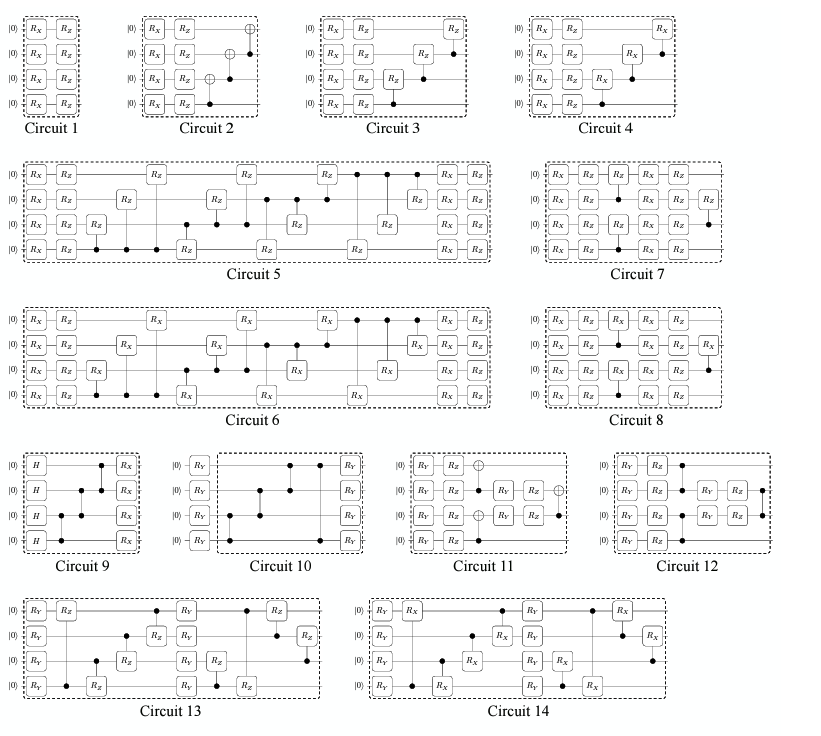

In [419]:
from qiskit import QuantumCircuit

def ansatz2(params):
    qc = QuantumCircuit(qnum_city)
    len_parm_2 = int(qnum_city/2) 
    # Apply Rx and Rz gates to each qubit
    for q in range(qnum_city):
        qc.rx(params[q], q)
    for q2 in range(qnum_city):#後半
        qc.rz(params[qnum_city+q2], q2) 
    # Apply CNOT gates 
    for q in range(1, qnum_city):
        qc.cx(q, q-1)
    return qc


def ansatz3(params):
    D = 1
    qc = QuantumCircuit(qnum_city)
    # Define the circuit for D iterations
    for _ in range(D):
        # Apply Ry and Rz gates to each qubit
        for q in range(qnum_city):
            qc.ry(params[q], q)  # Replace theta_y with the actual angle for the Ry gate
            qc.rz(params[qnum_city+q], q)  # Replace theta_z with the actual angle for the Rz gate

        # Apply CNOT gates in a chain
        for qubit in range(qnum_city - 1):
            qc.cx(qubit, qubit + 1)
        qc.barrier()
        
    for q in range(qnum_city):
        qc.ry(params[2*qnum_city+q], q)  
        qc.rz(params[3*qnum_city+q], q) 
    return qc


def ansatz4(params):#36個のparam
    num_qubits = qnum_city
    
    qc = QuantumCircuit(num_qubits)
    # Add a unique u3 gate for each qubit with parameters from the 'params' array
    for qubit in range(num_qubits):
        # Calculate the starting index of parameters for the current qubit
        start_index = qubit * 3
        # Extract the parameters for the current qubit
        theta, phi, lam = params[start_index:start_index+3]
        # Apply the u3 gate to the current qubit with the extracted parameters
        qc.u(theta, phi, lam, qubit)
        
        
    for qubit in range(num_qubits-1):
        ex_u = UGate(params[qubit], np.pi, params[qubit+1]).control(1)
        qc.append(ex_u, [qubit, qubit+1])

    # Apply the controlled-U gate between the last qubit and the first qubit
    ex_u = UGate(params[-1], np.pi, params[0]).control(1)
    qc.append(ex_u, [num_qubits-1, 0])

    return qc

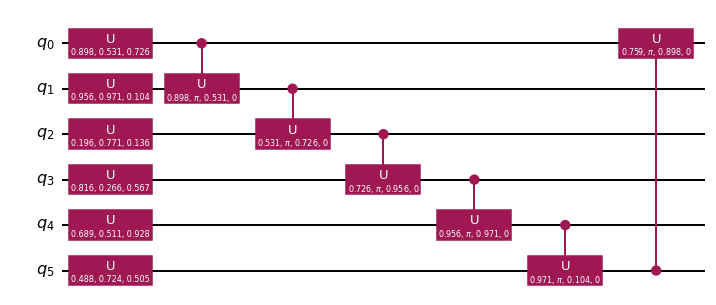

In [429]:
ansatz = ansatz4(params)
ansatz.draw("mpl",style="iqp")

In [443]:
from qiskit import QuantumCircuit

# 目的関数を定義します
def objective_function(params):
    qc_output = ansatz4(params)
    backend = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(qc_output.measure_all(inplace=False), backend=backend)
    job = backend.run(transpiled_circuit, shots=10**3)
    results = job.result()
    counts = results.get_counts()
    
    
    output_state = counts_to_distr(counts)
    
    #ここの計算量 .... 
    cost = sum(
        abs(target_state.get(i,0) - output_state.get(i,0)) for i in range(2**qc.num_qubits)
    )
    return cost

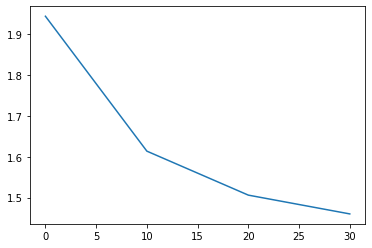

In [444]:
itr_cost = []
# 初期パラメータ
#numparm_circ2 = qnum_city*2
#numparm_circ3 = qnum_city*4
#numparm_circ4 = qnum_city*6
num_parm = qnum_city*6
params = np.random.rand(num_parm)
itr_list = [10*i for i in range(4)]
for i in itr_list:
    optimizer = COBYLA(maxiter=i, tol=0.0001)
    params = np.random.rand(num_parm)
    #result.x で最適化したパラメータを返す
    result = optimizer.minimize(
        fun=objective_function,
        x0=params)
    itr_cost.append(objective_function(result.x))
    
plt.plot(itr_list,itr_cost)

In [448]:
# 最適化アルゴリズムの初期化
optimizer = COBYLA(maxiter=20, tol=0.0001)

# 初期パラメータ
#numparm_circ2 = qnum_city*2
#numparm_circ3 = qnum_city*4
#params = np.random.rand(num_parm)

# 最適化プロセス
result = optimizer.minimize(objective_function, params)
opt_params = result.x
print("Optimized Parameters:", opt_params)

Optimized Parameters: [1.14698251 1.48453479 0.82906629 1.7259895  1.65097756 1.35591662
 0.02414438 0.97289975 0.35595934 1.77927915 1.01397141 1.97648779
 0.39419462 0.76343028 0.75738765 0.78859762 1.8281509  0.97253497
 0.03174978 0.1406699  0.31696248 0.531016   0.43340449 0.32467794
 0.46611977 0.15851243 0.33604546 0.20582545 0.31116577 0.70061669
 0.67462513 0.93716582 0.57583593 0.51993121 0.37353121 0.47566734]


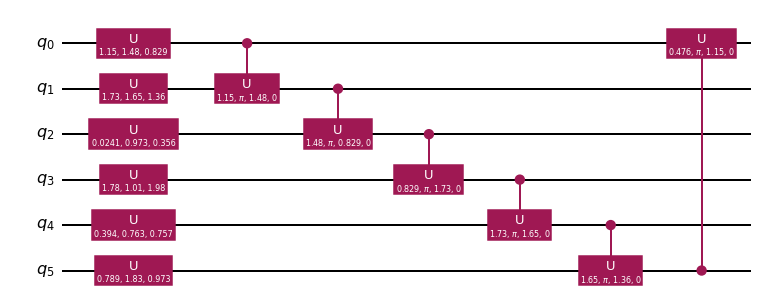

In [450]:
# 最適化されたアンザッツを表示
optimized_ansatz = ansatz4(opt_params)
optimized_ansatz.draw("mpl", style="iqp")

In [451]:
counts = backend.run(optimized_ansatz.measure_all(inplace=False), shots=1000).result().get_counts()
output_state = counts_to_distr(counts)

In [452]:
print("Parameters Found:", result.x)
print("Target Distribution:", target_state)
print("Obtained Distribution:", output_state)
print("Cost:", objective_function(result.x))

Parameters Found: [1.14698251 1.48453479 0.82906629 1.7259895  1.65097756 1.35591662
 0.02414438 0.97289975 0.35595934 1.77927915 1.01397141 1.97648779
 0.39419462 0.76343028 0.75738765 0.78859762 1.8281509  0.97253497
 0.03174978 0.1406699  0.31696248 0.531016   0.43340449 0.32467794
 0.46611977 0.15851243 0.33604546 0.20582545 0.31116577 0.70061669
 0.67462513 0.93716582 0.57583593 0.51993121 0.37353121 0.47566734]
Target Distribution: {24: 0.162109375, 9: 0.173828125, 36: 0.16796875, 33: 0.1669921875, 18: 0.1689453125, 6: 0.16015625}
Obtained Distribution: {63: 0.001, 39: 0.003, 42: 0.01, 11: 0.003, 46: 0.003, 47: 0.001, 62: 0.006, 18: 0.006, 38: 0.018, 35: 0.001, 22: 0.005, 58: 0.009, 32: 0.014, 31: 0.001, 7: 0.003, 49: 0.001, 33: 0.007, 16: 0.007, 25: 0.055, 10: 0.065, 40: 0.021, 14: 0.026, 59: 0.003, 24: 0.074, 17: 0.003, 34: 0.01, 8: 0.087, 3: 0.004, 41: 0.005, 30: 0.011, 48: 0.001, 9: 0.068, 57: 0.005, 2: 0.077, 56: 0.016, 1: 0.089, 26: 0.055, 0: 0.105, 6: 0.121}
Cost: 1.417999

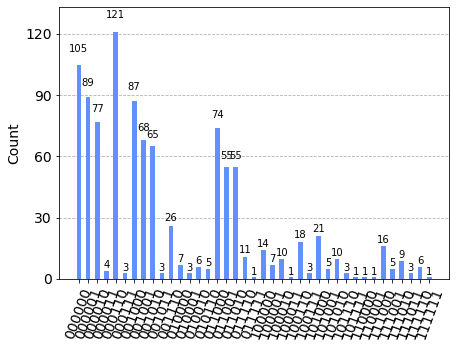

In [453]:
# 量子回路をトランスパイルします
#transpiled_circuit = transpile(optimized_ansatz.measure_all(inplace=False), backend=backend)

plot_histogram(counts)

In [399]:
output_state

{59: 0.001,
 2: 0.002,
 48: 0.259,
 9: 0.003,
 7: 0.002,
 1: 0.01,
 50: 0.002,
 53: 0.008,
 61: 0.004,
 5: 0.007,
 6: 0.031,
 60: 0.103,
 15: 0.026,
 54: 0.033,
 10: 0.012,
 57: 0.003,
 63: 0.031,
 51: 0.068,
 12: 0.107,
 3: 0.057,
 13: 0.003,
 55: 0.003,
 49: 0.013,
 58: 0.009,
 0: 0.203}

In [503]:
from qiskit import QuantumCircuit, Aer, transpile, execute
import numpy as np

# ターゲット状態
target_state = {
    "000110": 0.162109375,
    "001001": 0.173828125,
    "010010": 0.16796875,
    "011000": 0.1669921875,
    "100001": 0.1689453125,
    "100100": 0.16015625
}

def ansatz(params):
    qc = QuantumCircuit(qnum_city)
    len_parm_2 = int(qnum_city/2) 
    # Apply Rx and Rz gates to each qubit
    for q in range(qnum_city):
        qc.rx(params[q], q)
    for q2 in range(qnum_city):#後半
        qc.rz(params[qnum_city+q2], q2) 
    # Apply CNOT gates 
    for q in range(1, qnum_city):
        qc.cx(q, q-1)
    return qc


# ターゲット状態とのコスト関数
def cost_function(params):
    qc = ansatz(params)
    backend = Aer.get_backend('statevector_simulator')
    transpiled_circuit = transpile(qc, backend)
    result = execute(transpiled_circuit, backend).result()
    statevector = result.get_statevector(qc)
    
    # 生成された状態とターゲット状態との距離を計算
    cost = 0
    for state, prob in target_state.items():
        idx = int(state, 2)
        cost += abs(statevector[idx]) ** 2 - prob
    
    return cost

# 初期パラメータ
num_params = 12
initial_params = np.random.rand(num_params)

# COBYLA アルゴリズムの初期化
optimizer = COBYLA(maxiter=10000, tol=0.0001)

# 最適化実行
result = optimizer.minimize(cost_function, x0=initial_params)

print("Optimized parameters:", result.x)
#print("Minimum cost:", result[1])


<ipython-input-503-716a89afe145>:32: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(transpiled_circuit, backend).result()


TypeError: int() can't convert non-string with explicit base

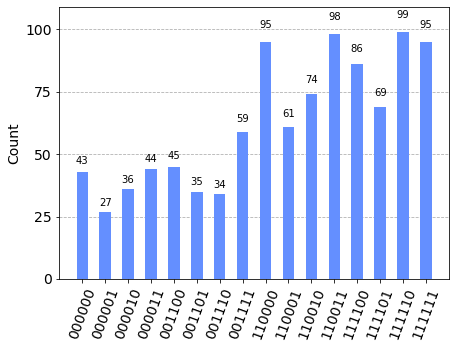

In [502]:
optimized_ansatz = ansatz(result.x)
counts = backend.run(optimized_ansatz.measure_all(inplace=False), shots=1000).result().get_counts()
plot_histogram(counts)

# 実験成功 Groverの終状態をVQEのansatz状態にする。

Optimized Parameters: [ 1.65791361  0.22161998 -0.0542405 ]


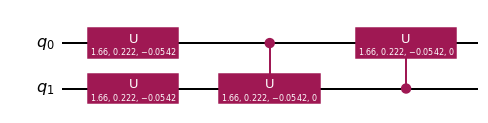

In [103]:
from qiskit import Aer, execute, transpile
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
import numpy as np
import math

# Grover回路を定義
def grover_circuit():
    qc = QuantumCircuit(2)
    qc.h([0,1])
    qc.mcp(math.pi,[0],1)
    qc.h([0,1])
    qc.x([0,1])
    qc.mcp(math.pi,[0],1)
    qc.x([0,1])
    qc.h([0,1])
    return qc

# Grover回路の測定結果を取得
target_state = AerSimulator().run(grover_circuit().measure_all(inplace=False)).result().get_counts()

# アンザッツ回路を定義
def ansatz1(params):
    qc = QuantumCircuit(2, name="|s>")
    qc.u(params[0], params[1], params[2], 0)
    qc.u(params[0], params[1], params[2], 1)
    ex_u = UGate(params[0], params[1], params[2]).control(1)
    qc.append(ex_u,[0,1])
    qc.append(ex_u,[1,0])
    return qc

# 目的関数を定義
def objective_function(params):
    qc = ansatz1(params)
    counts = AerSimulator().run(qc.measure_all(inplace=False)).result().get_counts()
    fidelity = 0
    for state in counts:
        fidelity += abs(np.sqrt(target_state.get(state, 0)) - np.sqrt(counts.get(state, 0)))**2
    return fidelity

# 最適化アルゴリズムの初期化
optimizer = COBYLA(maxiter=1000, tol=0.0001)

# 初期パラメータ
params = np.random.rand(3)

# 最適化プロセス
result = optimizer.minimize(objective_function, params)
opt_params = result.x

# 最適化されたアンザッツを表示
optimized_ansatz = ansatz1(opt_params)
print("Optimized Parameters:", opt_params)
optimized_ansatz.draw("mpl", style="iqp")

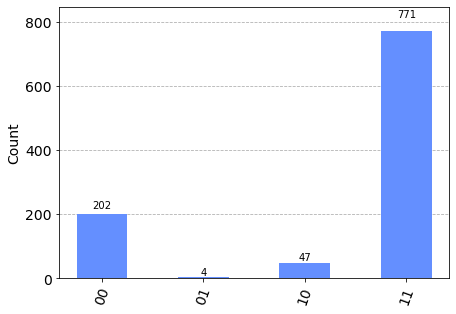

In [104]:
# 測定を実行
backend = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(optimized_ansatz.measure_all(inplace=False), backend=backend)
job = backend.run(transpiled_circuit, shots=1024)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)